<a href="https://colab.research.google.com/github/kuzmatsukanov/kuzma_omri_noa_data_project/blob/noa/image_identification_noa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocessing import Pool
from functools import partial


from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

For multiprocessing later on:

In [2]:
img_size = 80

In [3]:
def load_image(image_path, resize_shape=None):
    img = cv2.imread(image_path)
    if resize_shape is not None:
        img = cv2.resize(img, resize_shape)
    return img

def load_images_parallel(image_paths, n_jobs=4, resize_shape=None):
    with Pool(processes=n_jobs) as pool:
        func = partial(load_image, resize_shape=resize_shape)
        images = pool.map(func, image_paths)
    return np.array(images)

Mount the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/ds_project_dataset'

!cp -r "$shared_folder_path" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataframe

In [5]:
df = pd.read_csv('ds_project_dataset/articles.csv')

In [6]:
df.sample(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
71262,763285001,763285,Rana jumpsuit,267,Jumpsuit/Playsuit,Garment Full body,1010001,All over pattern,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,"Playsuit in viscose jersey with a V-neck, wrap..."
24061,607834007,607834,BROADWAY,259,Shirt,Garment Upper body,1010004,Check,93,Dark Green,...,Tops Woven,D,Divided,2,Divided,53,Divided Collection,1010,Blouses,"Long-sleeved, straight-cut shirt in an organic..."
22863,600544002,600544,GABBE FANCY BASIC,255,T-shirt,Garment Upper body,1010016,Solid,10,White,...,Kids Boy Jersey Fancy,H,Children Sizes 92-140,4,Baby/Children,46,Kids Boy,1005,Jersey Fancy,T-shirt in slub cotton jersey with a chest poc...
93849,859952001,859952,LE Bosch Dress,265,Dress,Garment Full body,1010016,Solid,53,Dark Pink,...,Limited Edition,A,Ladieswear,1,Ladieswear,82,Special Collections,1023,Special Offers,"Wide, straight-cut, calf-length dress in soft,..."
73286,771348003,771348,Monday jkt fleece lining,262,Jacket,Garment Upper body,1010001,All over pattern,51,Light Pink,...,Baby Boy Outdoor,G,Baby Sizes 50-98,4,Baby/Children,41,Baby Boy,1007,Outdoor,Fleece-lined jacket in a patterned weave with ...


In [7]:
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [8]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [9]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Lilac Purple',
       'Red', 'Mole', 'Orange', 'Metal', 'Brown', 'Turquoise', 'Yellow',
       'Khaki green', 'Green', 'undefined', 'Unknown', 'Yellowish Green',
       'Bluish Green'], dtype=object)

In [10]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

In [11]:
df['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

Relevant categories

In [12]:
selected_categories = ['Garment Upper body', 'Underwear', 'Socks & Tights', 'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags']
df = df[df['product_group_name'].isin(selected_categories)]

In [13]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags'],
      dtype=object)

In [14]:
selected_categories = ['undefined', 'Unknown']
df = df[~df['perceived_colour_master_name'].isin(selected_categories)]

In [15]:
df['perceived_colour_master_name'] = df['perceived_colour_master_name'].replace(['Khaki green', 'Yellowish Green', 'Bluish Green', 'Lilac Purple'], ['Green', 'Green', 'Green', 'Purple'])

<ipython-input-15-c4bef705f818>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perceived_colour_master_name'] = df['perceived_colour_master_name'].replace(['Khaki green', 'Yellowish Green', 'Bluish Green', 'Lilac Purple'], ['Green', 'Green', 'Green', 'Purple'])


In [16]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Purple', 'Red',
       'Brown', 'Green', 'Yellow', 'Orange', 'Turquoise', 'Mole', 'Metal'],
      dtype=object)

In [17]:
selected_categories = ['Other pattern', 'Unknown', 'Other structure']
df = df[~df['graphical_appearance_name'].isin(selected_categories)]

In [18]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Denim',
       'Colour blocking', 'Dot', 'Contrast', 'Treatment', 'Check',
       'Mixed solid/pattern', 'Placement print', 'Glittering/Metallic',
       'Neps', 'Embroidery', 'Application/3D', 'Chambray', 'Lace',
       'Front print', 'Transparent', 'Jacquard', 'Argyle', 'Slub',
       'Metallic', 'Mesh', 'Sequin', 'Hologram'], dtype=object)

In [19]:
selected_categories = ['Ladieswear', 'Menswear', 'Divided']
df = df[df['index_group_name'].isin(selected_categories)]

In [20]:
df.shape

(54933, 25)

In [21]:
df['subfolder'] = '0' + df['article_id'].astype(str).str[:2]
df['image_path'] = 'ds_project_dataset/images/' + df['subfolder'].str.strip() + '/0' + df['article_id'].astype(str) + '.jpg'

In [22]:
df['image_path']

0         ds_project_dataset/images/010/0108775015.jpg
1         ds_project_dataset/images/010/0108775044.jpg
2         ds_project_dataset/images/010/0108775051.jpg
3         ds_project_dataset/images/011/0110065001.jpg
4         ds_project_dataset/images/011/0110065002.jpg
                              ...                     
105536    ds_project_dataset/images/095/0952938001.jpg
105537    ds_project_dataset/images/095/0953450001.jpg
105538    ds_project_dataset/images/095/0953763001.jpg
105539    ds_project_dataset/images/095/0956217002.jpg
105541    ds_project_dataset/images/095/0959461001.jpg
Name: image_path, Length: 54933, dtype: object

In [23]:
df['image_path'][0]

'ds_project_dataset/images/010/0108775015.jpg'

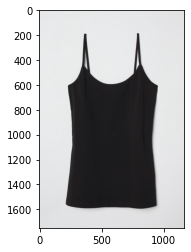

In [24]:
img = cv2.imread(df['image_path'][0])
plt.imshow(img)
plt.show()

For the training first trying to do the model on 10000 elements from the dataset as we have 90000 elements and it is already taking quite a long time.

In [25]:
valid_images = []
for index, row in tqdm(df[:11000].iterrows(), total=len(df[:11000])):
    if cv2.imread(row['image_path']) is not None:
        valid_images.append(row)

df_valid_images = pd.DataFrame(valid_images)

100%|██████████| 11000/11000 [06:31<00:00, 28.12it/s]


In [44]:
df_valid_images.shape

(10897, 27)

In [27]:
images = load_images_parallel(df_valid_images['image_path'].values, n_jobs=4, resize_shape=(img_size, img_size))

Encoding for the model

In [28]:
new_df = pd.DataFrame(df_valid_images['article_id'])

In [29]:
new_df

,article_id
0,108775015
1,108775044
2,108775051
3,110065001
4,110065002
...,...
20393,588689014
20396,588714005
20397,588748001
20398,588754002


In [30]:
new_df = new_df.join(pd.get_dummies(df_valid_images['perceived_colour_master_name'], prefix='colour'))
new_df = new_df.join(pd.get_dummies(df_valid_images['product_group_name'], prefix='product'))
new_df = new_df.join(pd.get_dummies(df_valid_images['graphical_appearance_name'], prefix='pattern'))
new_df = new_df.join(pd.get_dummies(df_valid_images['index_group_name'], prefix='index'))

In [31]:
new_df.sample(5)

,article_id,colour_Beige,colour_Black,colour_Blue,colour_Brown,colour_Green,colour_Grey,colour_Metal,colour_Mole,colour_Orange,...,pattern_Placement print,pattern_Sequin,pattern_Slub,pattern_Solid,pattern_Stripe,pattern_Transparent,pattern_Treatment,index_Divided,index_Ladieswear,index_Menswear
2651,420396005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5369,495030002,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12369,552866002,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9283,532098001,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
10650,542413002,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [32]:
color_array = new_df.filter(like='colour_').to_numpy()
pattern_array = new_df.filter(like='pattern_').to_numpy()
type_array = new_df.filter(like='product_').to_numpy()
index_array = new_df.filter(like='index_').to_numpy()

In [33]:
color_array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

Splitting + Model

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_color_train, y_color_val, y_type_train, y_type_val, y_pattern_train, y_pattern_val, y_index_train, y_index_val = train_test_split(
    images, color_array, type_array, pattern_array, index_array, test_size=0.2, random_state=42
)

In [35]:
inputs = Input(shape=(img_size, img_size, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

color_output = Dense(len(df_valid_images['perceived_colour_master_name'].unique()), activation='softmax', name='color_output')(x)
type_output = Dense(len(df_valid_images['product_group_name'].unique()), activation='softmax', name='type_output')(x)
pattern_output = Dense(len(df_valid_images['graphical_appearance_name'].unique()), activation='softmax', name='pattern_output')(x)
index_output = Dense(len(df_valid_images['index_group_name'].unique()), activation='softmax', name='index_output')(x)

model = Model(inputs=inputs, outputs=[color_output, type_output, pattern_output, index_output])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 78, 78, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 39, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 37, 37, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [36]:
model.compile(
    optimizer='adam',
    loss={
        'color_output': 'categorical_crossentropy',
        'type_output': 'categorical_crossentropy',
        'pattern_output': 'categorical_crossentropy',
        'index_output': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [37]:
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_color_output_accuracy',
    mode='max',
    save_best_only=True)

In [38]:
history = model.fit(
    X_train,
    {'color_output': y_color_train, 'type_output': y_type_train, 'pattern_output': y_pattern_train, 'index_output':y_index_train},
    validation_data=(
        X_val,
        {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val, 'index_output':y_index_val}
    ),
    epochs=20,
    batch_size=32,
    callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

scores = model.evaluate(
    X_val,
    {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val, 'index_output':y_index_val}
)


Epoch 1/20
273/273 [==============================] - 19s 17ms/step - loss: 10.1591 - color_output_loss: 3.2584 - type_output_loss: 1.8726 - pattern_output_loss: 3.0181 - index_output_loss: 2.0099 - color_output_accuracy: 0.4390 - type_output_accuracy: 0.6753 - pattern_output_accuracy: 0.5384 - index_output_accuracy: 0.5334 - val_loss: 4.7073 - val_color_output_loss: 1.4707 - val_type_output_loss: 0.7420 - val_pattern_output_loss: 1.5460 - val_index_output_loss: 0.9486 - val_color_output_accuracy: 0.5032 - val_type_output_accuracy: 0.7454 - val_pattern_output_accuracy: 0.5757 - val_index_output_accuracy: 0.5807
Epoch 2/20
273/273 [==============================] - 5s 17ms/step - loss: 4.2157 - color_output_loss: 1.2611 - type_output_loss: 0.6411 - pattern_output_loss: 1.4417 - index_output_loss: 0.8718 - color_output_accuracy: 0.6071 - type_output_accuracy: 0.7848 - pattern_output_accuracy: 0.5997 - index_output_accuracy: 0.6012 - val_loss: 4.0667 - val_color_output_loss: 1.1680 - val_

In [45]:
print('Validation Accuracy - Color: {:.2f}%, Type: {:.2f}%, Pattern: {:.2f}%, Index: {:.2f}%'.format(scores[5] * 100, scores[6] * 100, scores[7] * 100, scores[8] * 100))

Validation Accuracy - Color: 70.14%, Type: 84.82%, Pattern: 61.56%, Index: 67.29%


On new image

In [50]:
index_to_try = 10

In [51]:
# Load a new image
new_image_path = df['image_path'][index_to_try]
new_image = cv2.imread(new_image_path)

# Resize the image to 224x224
new_image_resized = cv2.resize(new_image, (img_size, img_size))

# Make a prediction on the new image
color_pred, type_pred, pattern_pred, index_pred = model.predict(np.array([new_image_resized]))

1/1 [==============================] - 0s 63ms/step


In [52]:
np.round(color_pred).astype(int), np.round(type_pred).astype(int), np.round(pattern_pred).astype(int), np.round(index_pred).astype(int)

(array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 1, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0]]),
 array([[0, 1, 0]]))

In [53]:
color_array[index_to_try], type_array[index_to_try], pattern_array[index_to_try], index_array[index_to_try]

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 1, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0], dtype=uint8),
 array([0, 1, 0], dtype=uint8))